In [2]:
#core libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#set chart size
plt.rcParams["figure.figsize"] = (10,5)

#path to data file
data_path = Path("retail_sales.csv")

# Load and Inspect Data

#load data into a DataFrame
df = pd.read_csv(data_path)

#look at first few rows of the DataFrame
df.head()

#info about columns and types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   transactions_id  2000 non-null   int64  
 1   sale_date        2000 non-null   object 
 2   sale_time        2000 non-null   object 
 3   customer_id      2000 non-null   int64  
 4   gender           2000 non-null   object 
 5   age              1990 non-null   float64
 6   category         2000 non-null   object 
 7   quantity         1997 non-null   float64
 8   price_per_unit   1997 non-null   float64
 9   cogs             1997 non-null   float64
 10  total_sale       1997 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 172.0+ KB


In [4]:
#standardize column names
df.columns = df.columns.str.lower().str.replace(" ", "_")

#rename columns for test purposes
col_map = {"transactions_id": "transaction_id"}
df = df.rename(columns=col_map)

#check columns
print(df.columns.tolist())

['transaction_id', 'sale_date', 'sale_time', 'customer_id', 'gender', 'age', 'category', 'quantity', 'price_per_unit', 'cogs', 'total_sale']


In [9]:
#convert sale_date to datetime format
df["sale_date"] = pd.to_datetime(df["sale_date"])

#convert sale_time to time objects
df["sale_time"] = pd.to_datetime(df["sale_time"], format="%H:%M:%S").dt.time

#make sure numeric fields are in correct format
for c in  ["age", "quantity", "price_per_unit", "cogs", "total_sale"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

#drop rows with missing values
df = df.dropna(subset=["transaction_id","sale_date","sale_time","customer_id", "category","quantity","cogs","total_sale"])

#check results
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1997 non-null   int64         
 1   sale_date       1997 non-null   datetime64[ns]
 2   sale_time       1997 non-null   object        
 3   customer_id     1997 non-null   int64         
 4   gender          1997 non-null   object        
 5   age             1987 non-null   float64       
 6   category        1997 non-null   object        
 7   quantity        1997 non-null   float64       
 8   price_per_unit  1997 non-null   float64       
 9   cogs            1997 non-null   float64       
 10  total_sale      1997 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 187.2+ KB


In [20]:
# Extract hour from the sale_time for later grouping
df["sale_hour"] = pd.to_datetime(df["sale_time"].astype(str), format="%H:%M:%S", errors="coerce").dt.hour

#create a shift column: Morning <12, Afternoon 12-17, Evening 17+
def to_shift(h):
    if pd.isna(h):
        return None
    if h < 12:
        return "Morning"
    if 12 <= h <= 17:
        return "Afternoon"
    return "Evening"

df["shift"] = df["sale_hour"].apply(to_shift)

#calculate profit
df["profit"] = df["total_sale"] - df["cogs"]
#check results
df[["sale_time", "shift", "total_sale", "profit"]].head(1000)


,sale_time,shift,total_sale,profit
0,10:47:00,Morning,900.0,771.0
1,11:00:00,Morning,1500.0,1355.0
2,10:48:00,Morning,1200.0,1116.0
3,08:53:00,Morning,900.0,771.0
4,08:35:00,Morning,1500.0,1265.0
...,...,...,...,...
998,22:09:00,Evening,100.0,90.0
999,22:32:00,Evening,50.0,36.0
1000,18:02:00,Evening,1000.0,775.0
1001,18:53:00,Evening,30.0,18.3


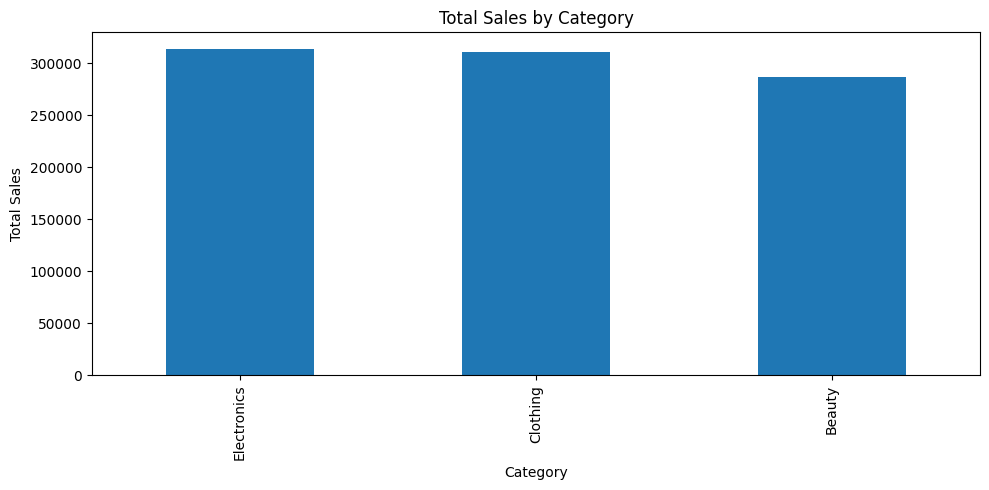

In [22]:
#group by category and sum total_sale
sales_by_category = df.groupby("category")["total_sale"].sum().sort_values(ascending=False)

#plot a bar chart
bc = sales_by_category.plot(kind="bar")
bc.set_title("Total Sales by Category")
bc.set_xlabel("Category")
bc.set_ylabel("Total Sales")
plt.tight_layout()
plt.show()

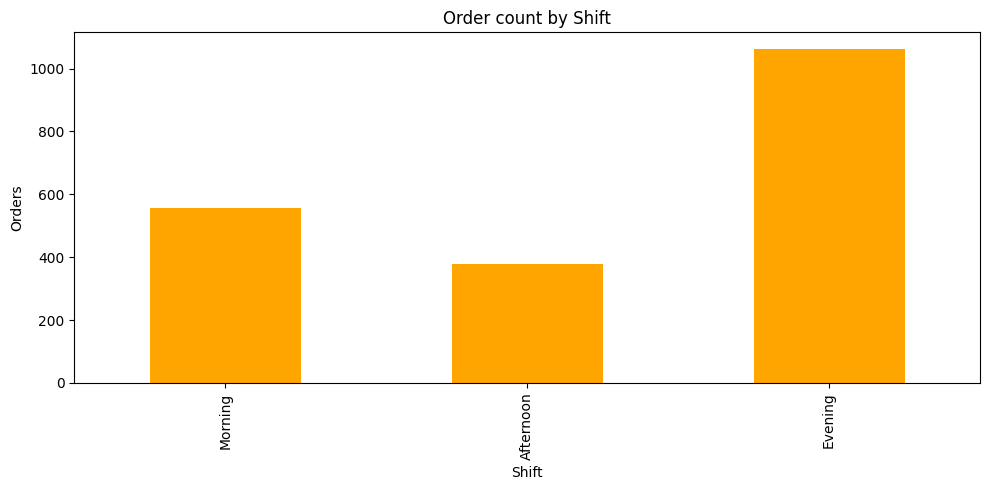

In [23]:
#Count how many orders in each shift
orders_by_shift = df["shift"].value_counts().reindex(["Morning", "Afternoon", "Evening"])

#plot a bar chart
bc = orders_by_shift.plot(kind="bar", color="orange")
bc.set_title("Order count by Shift")
bc.set_xlabel("Shift")
bc.set_ylabel("Orders")
plt.tight_layout()
plt.show()

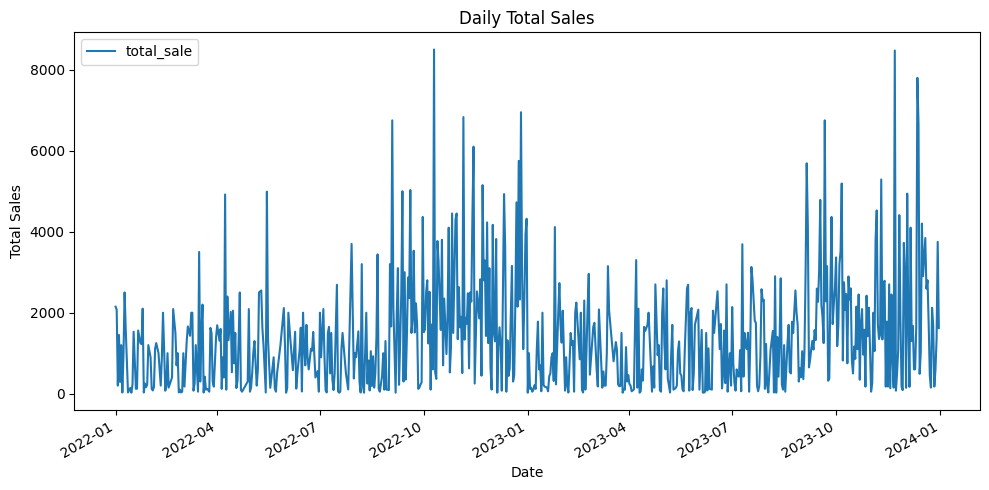

In [24]:
#Daily total Sales
daily_sales = df.groupby("sale_date")["total_sale"].sum().reset_index()

#plot a line chart
lc = daily_sales.plot(x="sale_date", y="total_sale", kind="line")
lc.set_title("Daily Total Sales")
lc.set_xlabel("Date")
lc.set_ylabel("Total Sales")
plt.tight_layout()
plt.show()


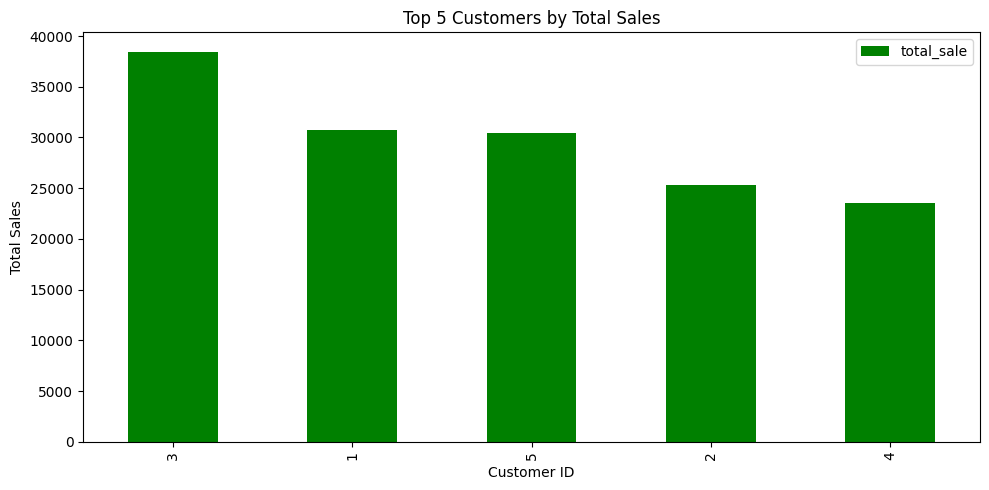

In [26]:
#Compute top 5 customers by total sales
top5 = (df.groupby("customer_id")["total_sale"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .reset_index()
       )
top5

#plot a bar chart
bc = top5.plot(x="customer_id", y="total_sale", kind="bar", color="green")
bc.set_title("Top 5 Customers by Total Sales")
bc.set_xlabel("Customer ID")
bc.set_ylabel("Total Sales")
plt.tight_layout()
plt.show()
